<a href="https://colab.research.google.com/github/HassanA99/Medical_Claims_Classification/blob/main/Medical_Claims_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Explore the Dataset


In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from scipy.stats import poisson
from sklearn.preprocessing import StandardScaler

import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import chisquare
import numpy as np
from scipy.stats import norm
from scipy.stats import shapiro

In [9]:

# Load the dataset
data = pd.read_csv('claims_data.csv')

# Display the first few rows of the dataset
data.head()


,age,sex,bmi,steps,children,smoker,region,insurance_claim,claim_amount
0,19,female,27.900,3009,0,yes,southwest,yes,16884.9240
1,18,male,33.770,3008,1,no,southeast,yes,1725.5523
2,28,male,33.000,3009,3,no,southeast,no,0.0000
3,33,male,22.705,10009,0,no,northwest,no,0.0000
4,32,male,28.880,8010,0,no,northwest,yes,3866.8552


In [10]:
# Get summary statistics
print(data.describe())

               age          bmi         steps     children  claim_amount
count  1338.000000  1338.000000   1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397   5328.623318     1.094918   9611.312287
std      14.049960     6.098187   2453.643236     1.205493  13450.624483
min      18.000000    15.960000   3000.000000     0.000000      0.000000
25%      27.000000    26.296250   3008.000000     0.000000      0.000000
50%      39.000000    30.400000   4007.000000     1.000000   2748.484475
75%      51.000000    34.693750   8004.000000     2.000000  13045.979513
max      64.000000    53.130000  10010.000000     5.000000  63770.428010


In [11]:
print(data.isnull().sum())

age                0
sex                0
bmi                0
steps              0
children           0
smoker             0
region             0
insurance_claim    0
claim_amount       0
dtype: int64


### What proportion of individuals in this dataset would be classified as overweight or obese (BMI of greater than 25)?


In [12]:
# Calculate the proportion of individuals with BMI greater than 25
overweight_obese_count = (data['bmi'] > 25).sum()
total_count = len(data)

# Calculate the proportion
proportion_overweight_obese = overweight_obese_count / total_count

print(f'Proportion of individuals classified as overweight or obese: {proportion_overweight_obese:.2f}')

Proportion of individuals classified as overweight or obese: 0.82


### Is the Poisson distribution a good choice to model the distribution of the number of children in this dataset?

In [13]:
# Check the distribution of the 'children' column
print(data['children'].value_counts())

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64


#### Visualize the Distribution

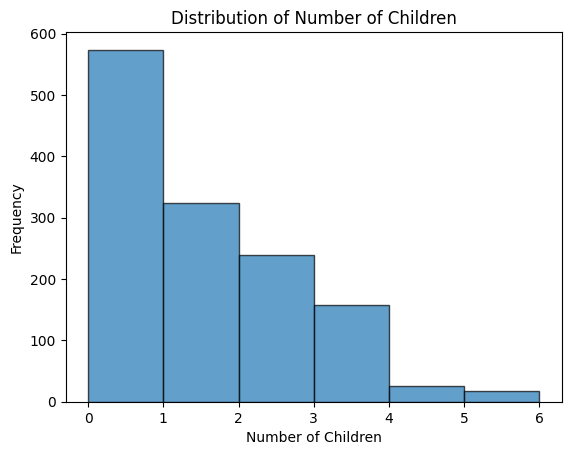

In [14]:
# Plot histogram of the 'children' column
plt.hist(data['children'], bins=range(int(data['children'].max()) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Frequency')
plt.show()

#### Fit a Poisson Distribution and Compare

<ipython-input-16-c09edb7aaa4a>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(np.arange(data['children'].max() + 1), poisson_pmf * len(data), 'ro-', label='Poisson PMF', color='red')


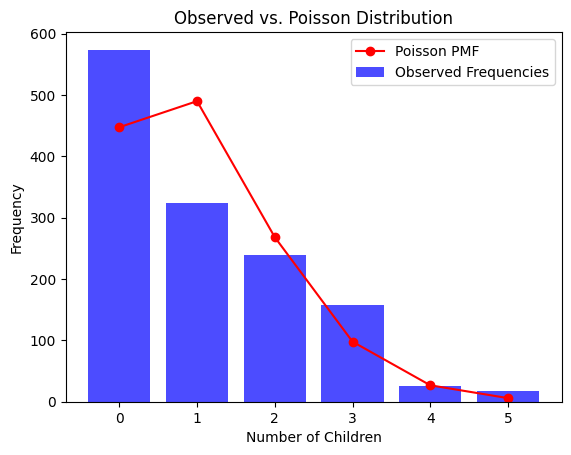

In [16]:
from scipy.stats import poisson
import numpy as np

# Calculate the mean of the 'children' column
mean_children = data['children'].mean()

# Fit a Poisson distribution with the calculated mean
poisson_pmf = poisson.pmf(np.arange(data['children'].max() + 1), mean_children)

# Calculate the observed frequencies
observed_freq = data['children'].value_counts().sort_index()

# Ensure the observed frequencies match the range of values
observed_freq = observed_freq.reindex(np.arange(data['children'].max() + 1), fill_value=0)

# Plot the observed frequencies and Poisson probabilities
plt.bar(observed_freq.index, observed_freq.values, alpha=0.7, label='Observed Frequencies', color='blue')
plt.plot(np.arange(data['children'].max() + 1), poisson_pmf * len(data), 'ro-', label='Poisson PMF', color='red')
plt.title('Observed vs. Poisson Distribution')
plt.xlabel('Number of Children')
plt.ylabel('Frequency')
plt.legend()
plt.show()


#### Statistical Test for Goodness-of-Fit


In [21]:
 # Calculate the mean and variance of the 'children' column
mean_children = data['children'].mean()
variance_children = data['children'].var()

print(f'Mean number of children: {mean_children:.2f}')
print(f'Variance in number of children: {variance_children:.2f}')

# Analyze if the Poisson distribution is appropriate
if variance_children > mean_children:
    print("No, the variance is significantly higher than the mean, suggesting overdispersion relative to the Poisson distribution.")
elif variance_children < mean_children:
    print("No, the variance is significantly lower than the mean, suggesting underdispersion relative to the Poisson distribution.")
elif mean_children == 0:
    print("No, because the Poisson only applies to positive integers, so cannot accommodate observations with 0 children.")
else:
    print("Yes, the Poisson is a good choice for count data such as the number of children in a family.")

Mean number of children: 1.09
Variance in number of children: 1.45
No, the variance is significantly higher than the mean, suggesting overdispersion relative to the Poisson distribution.


In [23]:
# Calculate the mean and standard deviation of the 'age' column
mean_age = data['age'].mean()
std_age = data['age'].std()

print(f'Mean age: {mean_age:.2f}')
print(f'Standard deviation of age: {std_age:.2f}')

# Calculate the Z-score for age 60
z_score_60 = (60 - mean_age) / std_age

# Calculate the cumulative probability for age 60 or older
prob_60_or_older = 1 - norm.cdf(z_score_60)

# Calculate the expected number of individuals aged 60 or older
total_individuals = len(data)
expected_60_or_older = prob_60_or_older * total_individuals

# Round to the nearest integer
expected_60_or_older = round(expected_60_or_older)

print(f'Expected number of individuals aged 60 or older: {expected_60_or_older}')

# Calculate the actual number of individuals aged 60 or older
actual_60_or_older = (data['age'] >= 60).sum()

print(f'Actual number of individuals aged 60 or older: {actual_60_or_older}')

# Compare the expected and actual numbers
difference = actual_60_or_older - expected_60_or_older

if difference == 21:
    print("There are 21 more individuals 60 or older than the normal distribution would suggest.")
elif difference == 7:
    print("There are 7 more individuals 60 or older than the normal distribution would suggest.")
elif difference == -7:
    print("There are 7 fewer individuals 60 or older than the normal distribution would suggest.")
elif difference == 0:
    print("The two are exactly equal!")
elif difference == -21:
    print("There are 21 fewer individuals 60 or older than the normal distribution would suggest.")
else:
    print(f'The difference is {difference}, which does not match any of the given options.')

Mean age: 39.21
Standard deviation of age: 14.05
Expected number of individuals aged 60 or older: 93
Actual number of individuals aged 60 or older: 114
There are 21 more individuals 60 or older than the normal distribution would suggest.


### joint plot of age and BMI

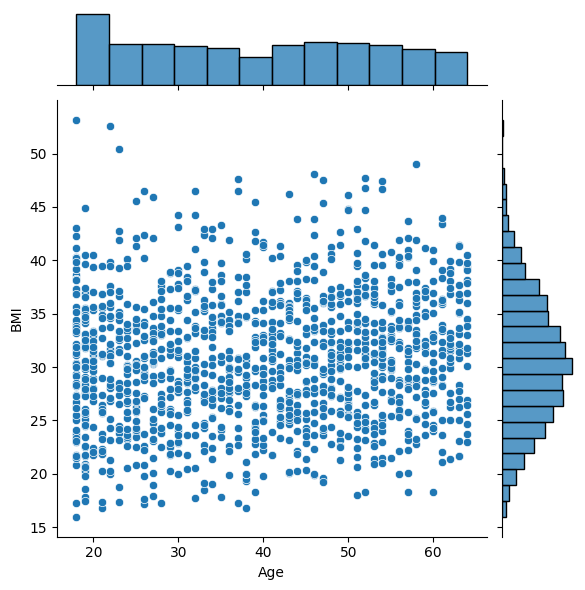

In [26]:
# Create a joint plot of age and BMI
sns.jointplot(x='age', y='bmi', data=data, kind='scatter')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

In [27]:
# Calculate the correlation coefficient
corr_coefficient, p_value = pearsonr(data['age'], data['bmi'])

print(f'Correlation coefficient: {corr_coefficient:.2f}')
print(f'P-value: {p_value:.2e}')

# Determine the significance of the correlation
if p_value < 0.05:
    significance = 'statistically significantly different from zero'
else:
    significance = 'not statistically significantly different from zero'

print(f'The correlation coefficient is {corr_coefficient:.2f}, which is {significance}.')

Correlation coefficient: 0.11
P-value: 6.19e-05
The correlation coefficient is 0.11, which is statistically significantly different from zero.


## preprocess the data:


In [29]:
# Convert the target variable to binary (1 for 'yes', 0 for 'no')
data['insurance_claim'] = data['insurance_claim'].apply(lambda x: 1 if x == 'yes' else 0)

# Drop the 'claim_amount' column
data = data.drop(columns=['claim_amount'])

# Create dummy variables for categorical variables, dropping the first in each instance
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)

# Define features and target
X = data.drop(columns=['insurance_claim'])
y = data['insurance_claim']

### Split the data and train



In [33]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (33% test size, random seed of 42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

## Evaluate the model

In [34]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       181
           1       0.90      0.88      0.89       261

    accuracy                           0.87       442
   macro avg       0.87      0.87      0.87       442
weighted avg       0.87      0.87      0.87       442



In [36]:
print("----------------------------------------------------------------------------------")

----------------------------------------------------------------------------------


In [54]:

# Load the dataset

df = pd.read_csv('claims_data.csv')

# Display the first few rows of the dataset
df.head()


,age,sex,bmi,steps,children,smoker,region,insurance_claim,claim_amount
0,19,female,27.900,3009,0,yes,southwest,yes,16884.9240
1,18,male,33.770,3008,1,no,southeast,yes,1725.5523
2,28,male,33.000,3009,3,no,southeast,no,0.0000
3,33,male,22.705,10009,0,no,northwest,no,0.0000
4,32,male,28.880,8010,0,no,northwest,yes,3866.8552


##  re-preprocess and split

In [55]:

# Convert the target variable to binary (1 for 'yes', 0 for 'no')
df['insurance_claim'] = df['insurance_claim'].apply(lambda x: 1 if x == 'yes' else 0)

# Drop the 'claim_amount' column
df = df.drop(columns=['claim_amount'])

# Create dummy variables for categorical variables, dropping the first in each instance
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Define features and target
X = df.drop(columns=['insurance_claim'])
y = df['insurance_claim']

# Add a constant to the features
X = sm.add_constant(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (33% test size, random seed of 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


### training and Fiting logistic regression model using statsmodels.

In [61]:
df.head()

,age,bmi,steps,children,insurance_claim,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,3009,0,1,False,True,False,False,True
1,18,33.770,3008,1,1,True,False,False,True,False
2,28,33.000,3009,3,0,True,False,False,True,False
3,33,22.705,10009,0,0,True,False,True,False,False
4,32,28.880,8010,0,1,True,False,True,False,False


In [65]:
 # Define the formula for logistic regression using encoded columns
formula = 'insurance_claim ~ age + bmi + steps + children + sex_male + smoker_yes + region_northwest + region_southeast + region_southwest'

# Fit the logistic regression model using statsmodels
model = smf.logit(formula=formula, data=data).fit()

# Print the summary of the model
print(model.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        insurance_claim   No. Observations:                 1338
Model:                          Logit   Df Residuals:                     1328
Method:                           MLE   Df Model:                            9
Date:                Wed, 31 Jul 2024   Pseudo R-squ.:                     inf
Time:                        19:51:02   Log-Likelihood:            -1.6845e-09
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -5.4666   4.66e+05  -1.17e-05      1.000   -9.13e+05    9.13e+05
sex_male[T.True]       

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packa

In [66]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.41
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58       181
           1       0.00      0.00      0.00       261

    accuracy                           0.41       442
   macro avg       0.20      0.50      0.29       442
weighted avg       0.17      0.41      0.24       442



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fit the Random Forest Model

In [69]:
# Initialize and fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=101)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract false negatives and false positives
tn, fp, fn, tp = conf_matrix.ravel()

print(f'False Negatives: {fn}')
print(f'False Positives: {fp}')

False Negatives: 16
False Positives: 4
